# with >1700 features and n=60 with repeat measures, there is a significan p>>n challenge

# Attempt feature reduction with hierarchical clustering
1. Complete linkage
2. distance = 1 - Pearson corr.
3. flat cluster with minimum threshold r=0.1 (such that the correlational distance between any two features in the cluster do not have a distance > 0.1, i.e. the Pearson correlation is less than 0.9)
    1. Tinker with this minimum distance until the RT/mz plots look OK

In [19]:
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import fcluster, linkage, dendrogram

from sklearn.preprocessing import StandardScaler

In [20]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic =     [1076, 1082, 1101]
impaired =     [1060, 1062, 1074, 1092, 1102]
normal =       [1091, 1093]
animal_tol = {
    1076: 'diabetic', 1082: 'diabetic', 1101: 'diabetic', 1060: 'impaired', 1062: 'impaired', 
    1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal'}
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='FBG|RBG').columns
fbg_cols = data.filter(regex='FBG').columns
rbg_cols = data.filter(regex='RBG').columns
pval_cols = data.filter(regex='pval').columns

n = data.filter(regex='1091|1093')                 # normal
i = data.filter(regex='1060|1062|1074|1092|1102')  # impaired
d = data.filter(regex='1076|1082|1101')            # diabetic

f = data[fbg_cols]  # fasted
r = data[rbg_cols]  # random-fed

fn = n.filter(fbg_cols)  # fasted normal 
fi = i.filter(fbg_cols)  # fasted impaired
fd = d.filter(fbg_cols)  # fasted diabetic

rn = n.filter(rbg_cols)  # random normal
ri = i.filter(rbg_cols)  # random impaired
rd = d.filter(rbg_cols)  # random diabetic

qval_sampling = data['fdr corrected pval effect of sampling']
qval_gtol = data['fdr corrected pval effect of glucose tolerance']
qval_cross = data['fdr corrected pval effect of interaction sampling and glucose tolerance']

In [21]:
X_all_centered = pd.DataFrame(StandardScaler(with_std=False).fit_transform(data[data_cols].T), 
                     index=data_cols, columns=data.index)
X_all_zscore = pd.DataFrame(StandardScaler().fit_transform(data[data_cols].T), index=data_cols, columns=data.index)

X_all = data[data_cols].T


y_3class = fg['gluc_tol']                                                 # ['normal', 'impaired', 'diabetic']
y_3class_num = y_3class.map({'normal': 0, 'impaired': 1, 'diabetic': 2})  # [0, 1, 2]
y_bg = fg['bg']                                                           # random/fasted blood glucoose
y_ogtt = fg['animal'].map(ap['OGTT (AUC)'])
y_weight = fg['animal'].map(ap['Weightprefastweek12'])
y_insulin = fg['animal'].map(ap['Insulin (AUC)'])

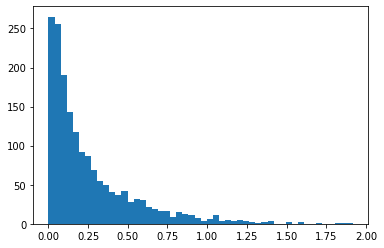

In [40]:
num_clusts = []
min_clust_dist = np.linspace(0.001, 0.99, 50)
for t in min_clust_dist:
    fc = fcluster(c, t=t, criterion='distance')
    num_clusts.append(len(set(fc)))

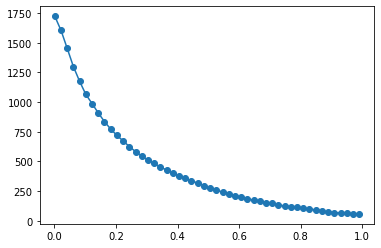

In [43]:
plt.plot(min_clust_dist, num_clusts, 'o-')

number of clusters after filtering by minimum distance: 281


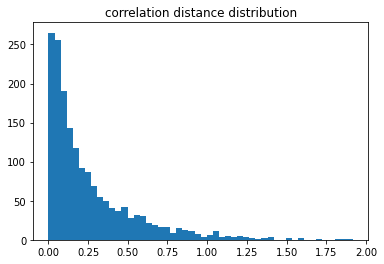

In [63]:
c = linkage(X_all.T, method='complete', metric='correlation')
plt.hist(c[:, 2], bins=50);
plt.title('correlation distance distribution')
fc = fcluster(c, t=0.5, criterion='distance')
print('number of clusters after filtering by minimum distance:', len(set(fc)))

clusts = pd.DataFrame({'clust_num': fc,}, index=X_all.columns)
representative_feats = clusts.drop_duplicates('clust_num').index

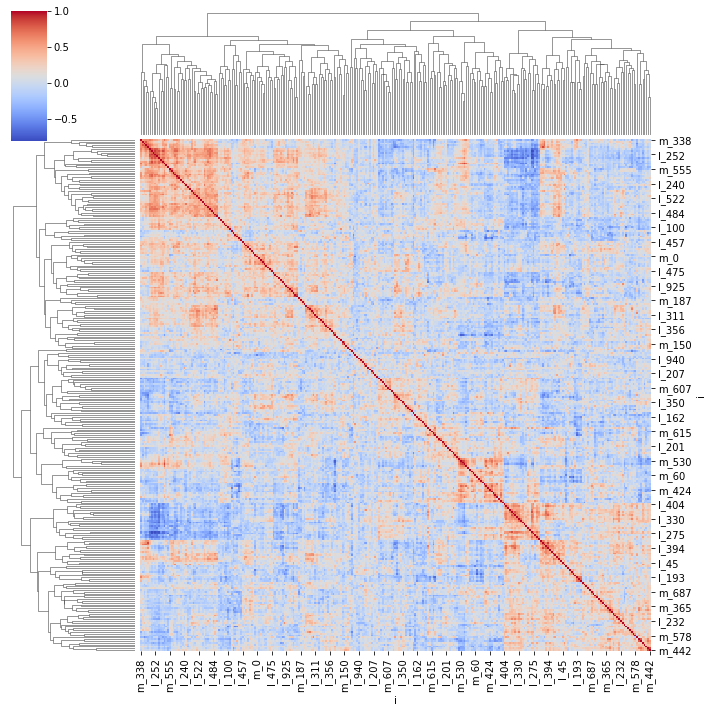

In [64]:
sns.clustermap(X_all.loc[:, representative_feats].corr(), cmap='coolwarm')